In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from sympy import (
    Derivative, 
    S, 
    Symbol, 
    series, 
    sqrt, 
    symbols, 
    oo, 
    limit, 
    Rational, 
    cos, 
    sin, 
    cosh, 
    sinh, 
    Matrix, 
    simplify, 
    latex, 
    lambdify,
    Function,
    collect
)
import numpy as np
from sympy import init_printing
init_printing() 

from sympy.printing.latex import print_latex
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib notebook

In [4]:
from acchamiltoniansandmatrices.Matrices.SymbMatrices import (
    RsymbFODO, 
    RsymbDrift6D, 
    RsymbQuad6D, 
    RsymbQuad6DChroma, 
    RsymbQuad6DThin
)
from acchamiltoniansandmatrices.Matrices.NumpyMatrices import (
    RnpFODO, 
    RnpDrift6D, 
    RnpQuad6D, 
    RnpQuad6DChroma, 
    RnpQuad6DThin
)
from acchamiltoniansandmatrices.Hamiltonians.LatticeElementHamiltonians import (
    HamDrift6D, 
    HamDrift6DParaxialSecondOrder, 
    HamQuad6D, 
    HamQuad6DParaxialSecondOrder, 
    HamQuad6DParaxialSecondOrderChroma,
)
from acchamiltoniansandmatrices.Hamiltonians.Operators import Poisson
from acchamiltoniansandmatrices.Tracking.LinearMatrixTracking import nestList, LinMap, GenerateNDimCoordinateGrid
from acchamiltoniansandmatrices.LieMaps.LieOperator import LieOperator
from acchamiltoniansandmatrices.LieMaps.Poisson import PoissonBracket

In [5]:
x, px, y, py, z, delta, eps, h , k0, k1, k2, sigma, betag ,f = symbols('x p_x y p_y z delta epsilon h k_0 k_1 k_2 sigma beta_gamma f', real=True)
L, beta0, gamma0 = symbols(" L beta_0 gamma_0", real=True, positive=True)

# Introduction

Before starting the effective calculations we give a short introduction to the package that takes care of the sympy implementation of the Poisson Bracket and the Lie Operator.

## Defining generic Functions

In [6]:
A = Function("A", commutative=False)(x,px)
B = Function("B", commutative=False)(x,px)
C = Function("C", commutative=False)(x,px)
D = Function("D", commutative=False)(x,px)
E = Function("E", commutative=False)(x,px)

## Defining Lie Operators

In [7]:
Aop = LieOperator(A,x,px)
Bop = LieOperator(B,x,px)
Cop = LieOperator(C,x,px)

## Basics

In [8]:
Aop

In [9]:
Aop.BCH(Bop,1)

In [10]:
Aop.BCH(Bop,2)

In [11]:
Aop.BCH(Bop,3)

In [12]:
Aop.BCH(Bop,4)

**Side note on displaying of expressions:**

The package still fails to print the first two arguments without the variables when displaying the Hamiltonian. The underlying cause is that these arguments are not custom defined, like the PoissonBracket, but native sympy objects. Due to this the lowest end of the recursive printing depends on the native implementation for these object. I did not figure out yet how to override these methods from within the custom classes.

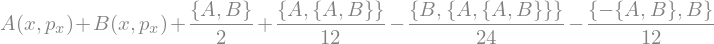

In [13]:
Aop.BCH(Bop,4).ham

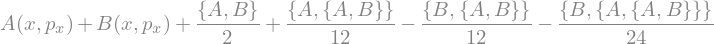

In [14]:
Aop.BCH(Bop,4).ham.expand(commutator=True)

# General

We  start by considering the following lattice:
$$A-B-C-D-E$$
where A,B,C,D,E are generic lattice elements and we consider the beam coming from the left (this important for the ordering of the operators).

The corresponding Lie map is given by:
$$e^{A}e^{B}e^{C}e^{D}e^{E}$$
and after the correct coordinate transformations this becomes:
$$e^{E}e^{D}e^{C}e^{B}e^{A}$$

The operators A,..,E in the exponents need to be combined using the BCH formula. Doing this order by order, where with order we mean the number of iterative Poisson brackets and not the order of the resulting polynomial in the independent coordinates, we get:
$$H_0 = A +B + C + D + E$$

For the higher orders we go step by step. Let us start by first having a look at $H_1$ for the first three elements.

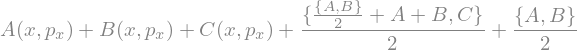

In [15]:
Aop.BCH(Bop,2).BCH(Cop,2).ham

Let us clean this up a bit by expanding the Poisson Brackets.

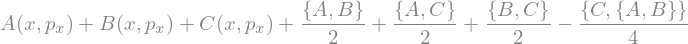

In [16]:
Aop.BCH(Bop,2).BCH(Cop,2).ham.expand(commutator=True)

One can immediately see the effect of the BCH formula, making things very complicated very quickly. 

An interesting question to ask is what happens if $C=A$.

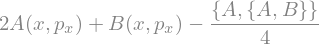

In [17]:
Aop.BCH(Bop,2).BCH(Cop,2).ham.expand(commutator=True).subs(C,A)

**The terms with a single Poisson bracket have been canceled out!**

Let us now break the symmetry lightly and assume that $C = A + \delta A$.

In [24]:
da = Function("\delta A", commutative=False)(x,px)
da

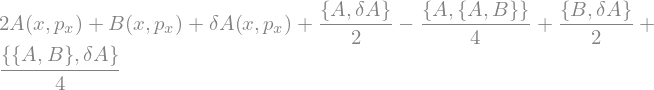

In [26]:
Aop.BCH(Bop,2).BCH(Cop,2).ham.expand(commutator=True).subs(C,A+da).expand(commutator=True)

Slightly breaking the symmetry between the elements $A$ and $C$ immediately introduces new terms
in the Hamiltonian:
$$2 A{\left(x,p_{x} \right)} + B{\left(x,p_{x} \right)} + \delta A{\left(x,p_{x} \right)} + 
\underbrace{\color{blue}{\frac{\lbrace A,\delta A \rbrace }{2}}}_{\color{red}{\text{SB1}}} 
- \frac{\lbrace A,\lbrace A,B \rbrace  \rbrace }{4} 
+ \underbrace{\color{blue}{\frac{\lbrace B,\delta A \rbrace }{2}}}_{\color{red}{\text{SB2}}}  + \frac{\lbrace \lbrace A,B \rbrace ,\delta A \rbrace }{4}$$
where SB stands for Symmetry Breaking. Note that these terms are directly proportional to the amount of symmetry breaking.

In [27]:
print_latex(Aop.BCH(Bop,2).BCH(Cop,2).ham.expand(commutator=True).subs(C,A+da).expand(commutator=True))

2 A{\left(x,p_{x} \right)} + B{\left(x,p_{x} \right)} + \delta A{\left(x,p_{x} \right)} + \frac{\lbrace A,\delta A \rbrace }{2} - \frac{\lbrace A,\lbrace A,B \rbrace  \rbrace }{4} + \frac{\lbrace B,\delta A \rbrace }{2} + \frac{\lbrace \lbrace A,B \rbrace ,\delta A \rbrace }{4}
